In [3]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.utilities import print_summary
import matplotlib.pyplot as plt
import pandas as pd

### Full yield curve data at 21/08/2024 from https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html

In [4]:
EU_par_yield = pd.DataFrame(
    {'Maturity': np.array([3/12,6/12,9/12,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]),
     'Yield': np.array([3.313588,3.094957,2.911334,2.757380,2.358434,2.177693,2.111791,2.105795,2.130061,2.168406,2.211936,\
                        2.255772,2.297283,2.335114,2.368647,2.397688,2.422290,2.442645,2.459020,2.471715,2.481045,2.487318,\
                        2.490833,2.491871,2.490694,2.487544,2.482643,2.476192,2.468377,2.459362,2.449299,2.438323,2.426556]) }
)

### Generating a somewhat realistic sample using all short term maturities and few medium to long term ones

In [5]:
sample = EU_par_yield.iloc[[0,1,2,3,4,5,7,12,22,32],:]
X = sample[['Maturity']].values
Y = sample[['Yield']].values

kernel = gpflow.kernels.SquaredExponential()
model = gpflow.models.GPR(data=(X, Y), kernel=kernel, mean_function=None)
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

### Optimizing the hyperparameters

In [6]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables)
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 11.0034     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  5.65531    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.00231034 │
╘═════════════════════════╧═══════════╧══════════════════╧══════

In [7]:
# Prediction points
maturities = np.linspace(0, 30, 30).reshape(-1, 1)

mean, var = model.predict_f(maturities)
gpmean = mean.numpy()
gpvar = var.numpy()

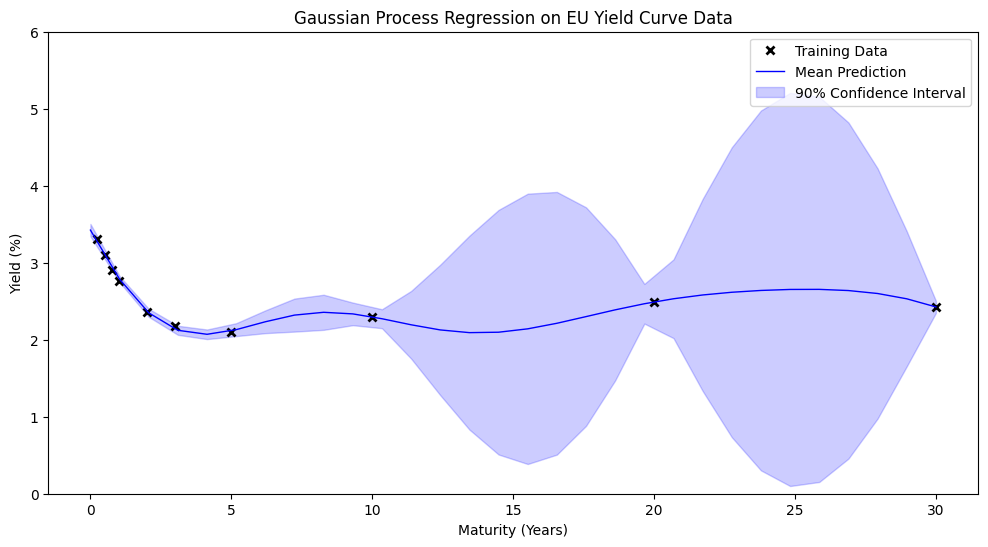

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2, label='Training Data')
plt.plot(maturities, gpmean, 'b', lw=1, label='Mean Prediction')
plt.fill_between(maturities.flatten(),
                 gpmean.flatten() - 1.645 * np.sqrt(gpvar.flatten()),
                 gpmean.flatten() + 1.645 * np.sqrt(gpvar.flatten()),
                 color='blue', alpha=0.2, label='90% Confidence Interval')
#plt.xticks(ticks = [])
plt.ylim((0,6))
plt.title('Gaussian Process Regression on EU Yield Curve Data')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.show()

In [14]:
kernel_1 = gpflow.kernels.SquaredExponential()
kernel_2 = gpflow.kernels.SquaredExponential()
kernel_3 = gpflow.kernels.SquaredExponential()

layer1 = gpflow.models.GPR(data = (X, Y), kernel=kernel_1, mean_function = None)
layer2 = gpflow.models.GPR(data = (X, layer1.predict_f(X)[0].numpy()), kernel=kernel_2, mean_function = None)
layer3 = gpflow.models.GPR(data = (X, layer2.predict_f(X)[0].numpy()), kernel=kernel_3, mean_function = None)
print_summary(layer1)
print_summary(layer2)
print_summary(layer3)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [15]:
optimizer = gpflow.optimizers.Scipy()

# Optimize each layer sequentially
for layer in [layer1, layer2, layer3]:
    optimizer.minimize(layer.training_loss, layer.trainable_variables)
    print_summary(layer)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 11.0034     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  5.65531    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.00231034 │
╘═════════════════════════╧═══════════╧══════════════════╧══════

In [17]:
layer1_mean, layer1_var = layer1.predict_f(maturities)
layer2_mean, layer2_var = layer2.predict_f(maturities)
layer3_mean, layer3_var = layer3.predict_f(maturities)

dgpmean = layer3_mean.numpy()
dgpvar = layer3_var.numpy()

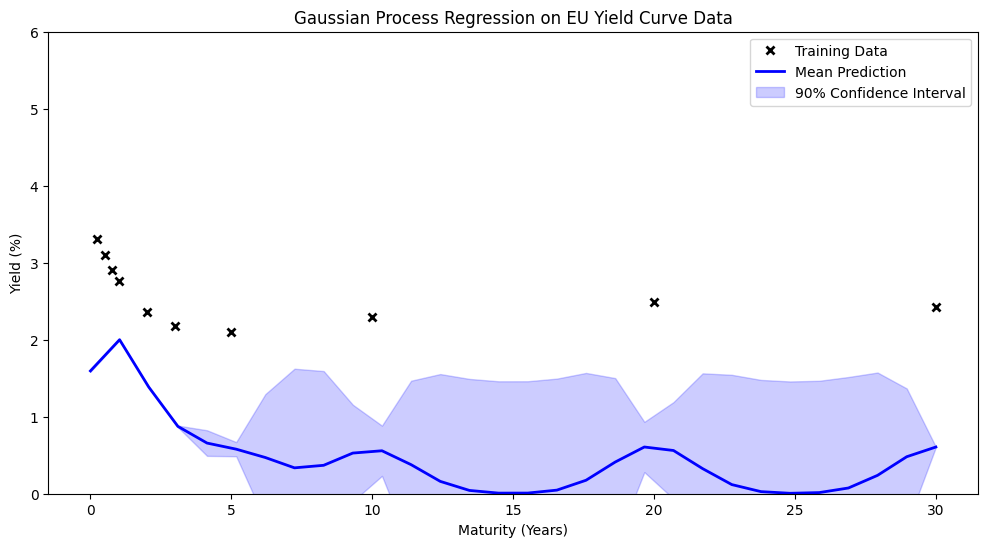

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2, label='Training Data')
plt.plot(maturities, dgpmean, 'b', lw=1, label='Mean Prediction')
plt.fill_between(maturities.flatten(),
                 dgpmean.flatten() - 1.645 * np.sqrt(dgpvar.flatten()),
                 dgpmean.flatten() + 1.645 * np.sqrt(dgpvar.flatten()),
                 color='blue', alpha=0.2, label='90% Confidence Interval')
#plt.xticks(ticks = [])
plt.ylim((0,6))
plt.title('Gaussian Process Regression on EU Yield Curve Data')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.show()

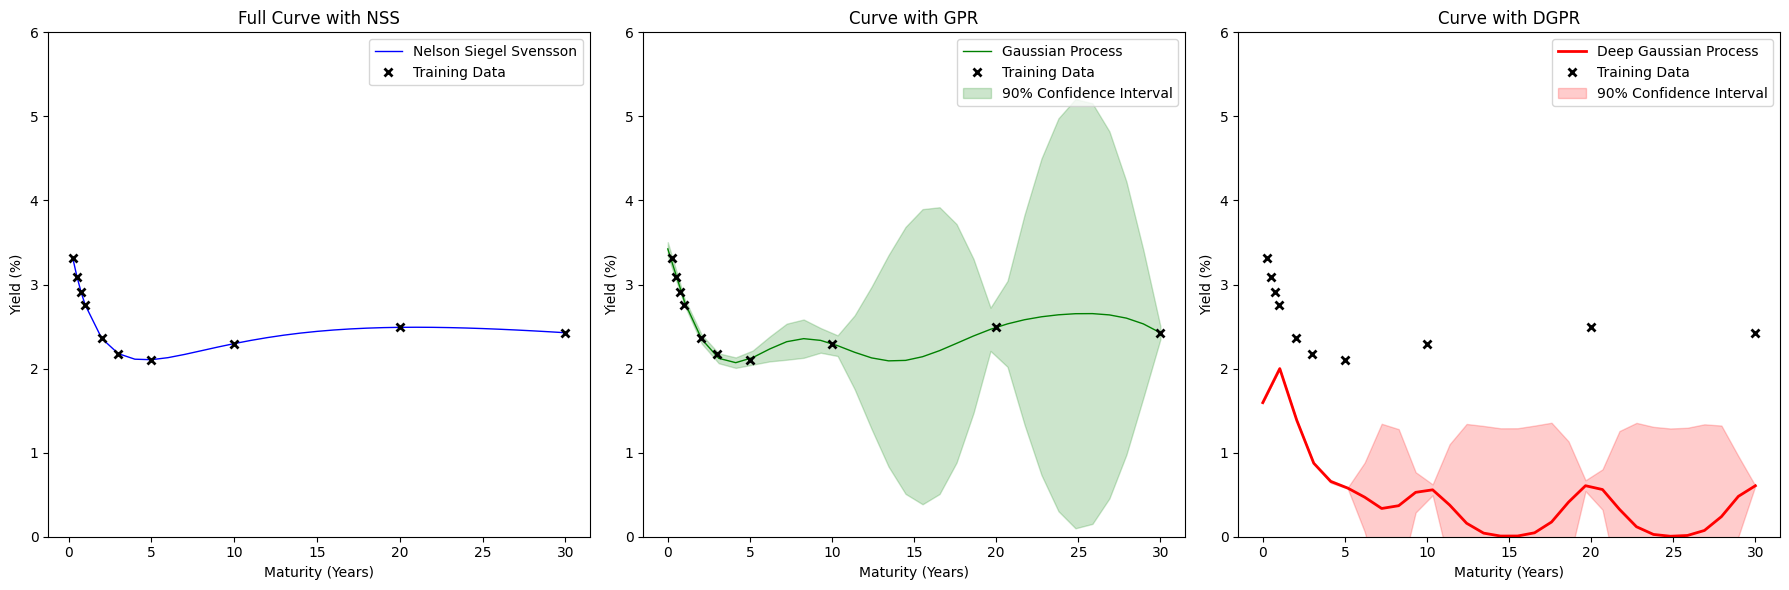

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(EU_par_yield['Maturity'],EU_par_yield['Yield'], 'b', lw = 1, label='Nelson Siegel Svensson')
ax[0].plot(X, Y, 'kx', mew=2, label='Training Data')
ax[0].set_title('Full Curve with NSS')
ax[0].set_xlabel('Maturity (Years)')
ax[0].set_ylabel('Yield (%)')
ax[0].legend()
ax[0].set_ylim((0,6))

# GP
ax[1].plot(maturities, gpmean, 'g', lw=1, label='Gaussian Process')
ax[1].plot(X, Y, 'kx', mew=2, label='Training Data')
ax[1].fill_between(maturities.flatten(),
                   gpmean.flatten() - 1.645 * np.sqrt(gpvar.flatten()),
                   gpmean.flatten() + 1.645 * np.sqrt(gpvar.flatten()),
                   color='green', alpha=0.2, label='90% Confidence Interval')
ax[1].set_title('Curve with GPR')
ax[1].set_xlabel('Maturity (Years)')
ax[1].set_ylabel('Yield (%)')
ax[1].legend()
ax[1].set_ylim((0,6))

# DGP
ax[2].plot(maturities, dgpmean, 'r', lw=2, label='Deep Gaussian Process')
ax[2].plot(X, Y, 'kx', mew=2, label='Training Data')
ax[2].fill_between(maturities.flatten(),
                   dgpmean.flatten() - 1.645 * dgpvar.flatten(),
                   dgpmean.flatten() + 1.645 * dgpvar.flatten(),
                   color='red', alpha=0.2, label='90% Confidence Interval')
ax[2].set_title('Curve with DGPR')
ax[2].set_xlabel('Maturity (Years)')
ax[2].set_ylabel('Yield (%)')
ax[2].legend()
ax[2].set_ylim((0,6))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()